<a href="https://colab.research.google.com/github/YifuYuan/Sleep_stage_classifier/blob/main/EEG_spectrogram_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf 'training_set_balanced'
!rm -rf 'test_set'

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
!unzip training_set_balanced.zip
!unzip test_set.zip

In [ ]:
IMAGE_HEIGHT = 154
IMAGE_WIDTH = 28
BATCH_SIZE = 25
N_CHANNELS = 3
N_CLASSES = 5

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory=os.path.join('/content', 'training_set_balanced'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory=os.path.join('/content', 'training_set_balanced'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

# Make test set
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0,
                                             directory=os.path.join('/content', 'test_set'),
                                             shuffle=False,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             seed=0)



Found 10000 files belonging to 5 classes.
Using 7000 files for training.
Found 10000 files belonging to 5 classes.
Using 3000 files for validation.
Found 1246 files belonging to 5 classes.


In [ ]:
plt.figure(figsize=(7, 36))
for images, labels in train_dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        # print(images)   
plt.show()

In [ ]:
# Create CNN model----modified
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten()) # reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor 
# model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
280/280 [==============================] - 3s 6ms/step - loss: 2.2026 - accuracy: 0.4479 - val_loss: 0.9632 - val_accuracy: 0.6037
Epoch 2/10
280/280 [==============================] - 2s 5ms/step - loss: 1.0388 - accuracy: 0.5801 - val_loss: 0.8627 - val_accuracy: 0.6417
Epoch 3/10
280/280 [==============================] - 2s 5ms/step - loss: 0.9571 - accuracy: 0.6031 - val_loss: 0.8460 - val_accuracy: 0.6523
Epoch 4/10
280/280 [==============================] - 2s 5ms/step - loss: 0.9202 - accuracy: 0.6241 - val_loss: 0.7858 - val_accuracy: 0.6877
Epoch 5/10
280/280 [==============================] - 2s 6ms/step - loss: 0.8748 - accuracy: 0.6556 - val_loss: 0.8956 - val_accuracy: 0.6327
Epoch 6/10
280/280 [==============================] - 2s 6ms/step - loss: 0.8548 - accuracy: 0.6629 - val_loss: 0.7889 - val_accuracy: 0.6927
Epoch 7/10
280/280 [==============================] - 2s 6ms/step - loss: 0.8656 - accuracy: 0.6614 - val_loss: 0.7597 - val_accuracy: 0.6880
Epoch 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 152, 26, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 76, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 74, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 5, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 35, 3, 128)        73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 1, 128)      

In [ ]:
# Get the confusion matrix
predictions = model.predict(test_dataset)
label_pred = np.array([])
for sub in predictions:
  max_idx = np.argmax(sub)
  label_pred = np.append(label_pred, max_idx)

test_label = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(test_label, label_pred)

accuracy_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = accuracy_matrix.diagonal()
print(cm)
print(accuracy)

50/50 [==============================] - 0s 2ms/step
[[ 63  67   6  22  64]
 [  6  48   7   1  52]
 [  8  64 445  64  35]
 [  2   0  16  94   2]
 [  9  41  29   4  97]]
[0.28378378 0.42105263 0.7224026  0.8245614  0.53888889]


In [ ]:
print(label_pred[0:20])
print(test_label[0:20])

[1. 0. 1. 1. 0. 0. 4. 0. 0. 3. 0. 4. 0. 0. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


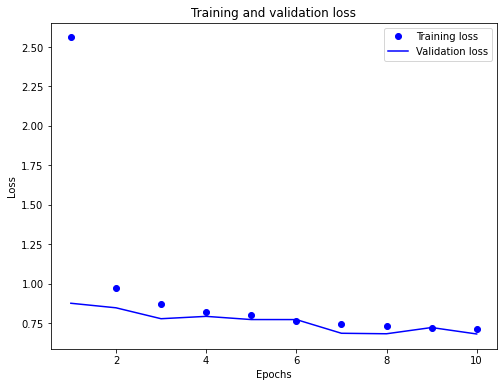

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

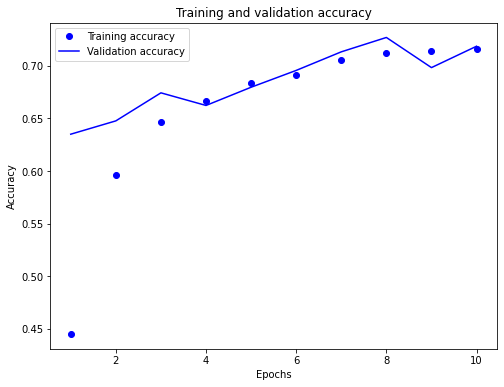

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)  
# test_dataset = prepare(valid_dataset, augment=False) 

In [ ]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
# history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)